# Save WN spiketimes
This relies on the quality-controlled cell type file generated for the noise chunk in `20240229C_wn_dataprep.ipynb`

In [2]:

import sys


# add paths to rgc_model, symphony_data, lnp, analysis_utils, datajoint, config, data_modules
sys.path.append('/Users/niloughazavi/Documents/GitHub/rgc_model')
sys.path.append('/Users/niloughazavi/Documents/GitHub/MEA/src/analysis/symphony_data')
sys.path.append('/Users/niloughazavi/Documents/GitHub/MEA/src/analysis/lnp')
sys.path.append('/Users/niloughazavi/Documents/GitHub/MEA/src/analysis/analysis_utils')
sys.path.append('/Users/niloughazavi/Documents/GitHub/datajoint')
sys.path.append('/Users/niloughazavi/Documents/GitHub/MEA/src/analysis/config')
sys.path.append('/Users/niloughazavi/Documents/GitHub/datajoint/data_modules')



import numpy as np
import matplotlib.pyplot as plt
import data_utils as du
import spikeoutputs as so
import spikeplots as sp
import meaqc
import eicorr
import importlib
import os
import pickle
importlib.reload(so)
importlib.reload(sp)
importlib.reload(meaqc)

<module 'meaqc' from '/Users/niloughazavi/Documents/GitHub/datajoint/data_modules/meaqc.py'>

In [3]:
d_meta = {'str_experiment': '20240229C',
          'str_protocol': 'dovesmovie',
          'str_algo': 'kilosort2',
          'paramsfile': '/Volumes/data/analysis/20240229C/chunk4/kilosort2/kilosort2.params',
          'dataset_name': 'kilosort2',
        # NOTE: This QC classification file was generated in doves_dataprep
        'str_classification': '/Volumes/data/analysis/20240229C/chunk4/kilosort2/vr_kilosort2.classification.txt',
          'ls_RGC_labels': ['OffP', 'OffM', 'OnP', 'OnM'],
          'ls_filenames': ['data013', 'data014'],
          'ls_noise_filenames': ['data018']}
data = so.SpikeOutputs(**d_meta)
data.load_sta_from_params(load_ei=True, load_neurons=True, 
                          isi_bin_edges=np.linspace(0,300,601), 
                          b_flip_y=True)

Loading STA RF fits from /Volumes/data/analysis/20240229C/chunk4/kilosort2/kilosort2.params...
Loaded STA RF fits for 951 cells.
Flipped y0 values, so RFs are in sta matrix space with (0,0) in top left.
Loading WN ISI...
Loading ISI for manookinlab.protocols.SpatialNoise ['data018']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 951 cells.


In [4]:
print(data.__dict__.keys())

dict_keys(['str_experiment', 'str_protocol', 'str_datafile', 'str_algo', 'str_noise_protocol', 'paramsfile', 'dataset_name', 'paramsmatfile', 'ls_filenames', 'ls_noise_filenames', 'ls_RGC_labels', 'stim', 'spikes', 'isi', 'ARR_CELL_IDS', 'str_classification', 'types', 'vcd', 'N_WIDTH', 'N_HEIGHT', 'NOISE_GRID_SIZE', 'd_sta', 'GOOD_CELL_IDS', 'N_CELLS', 'N_GOOD_CELLS'])


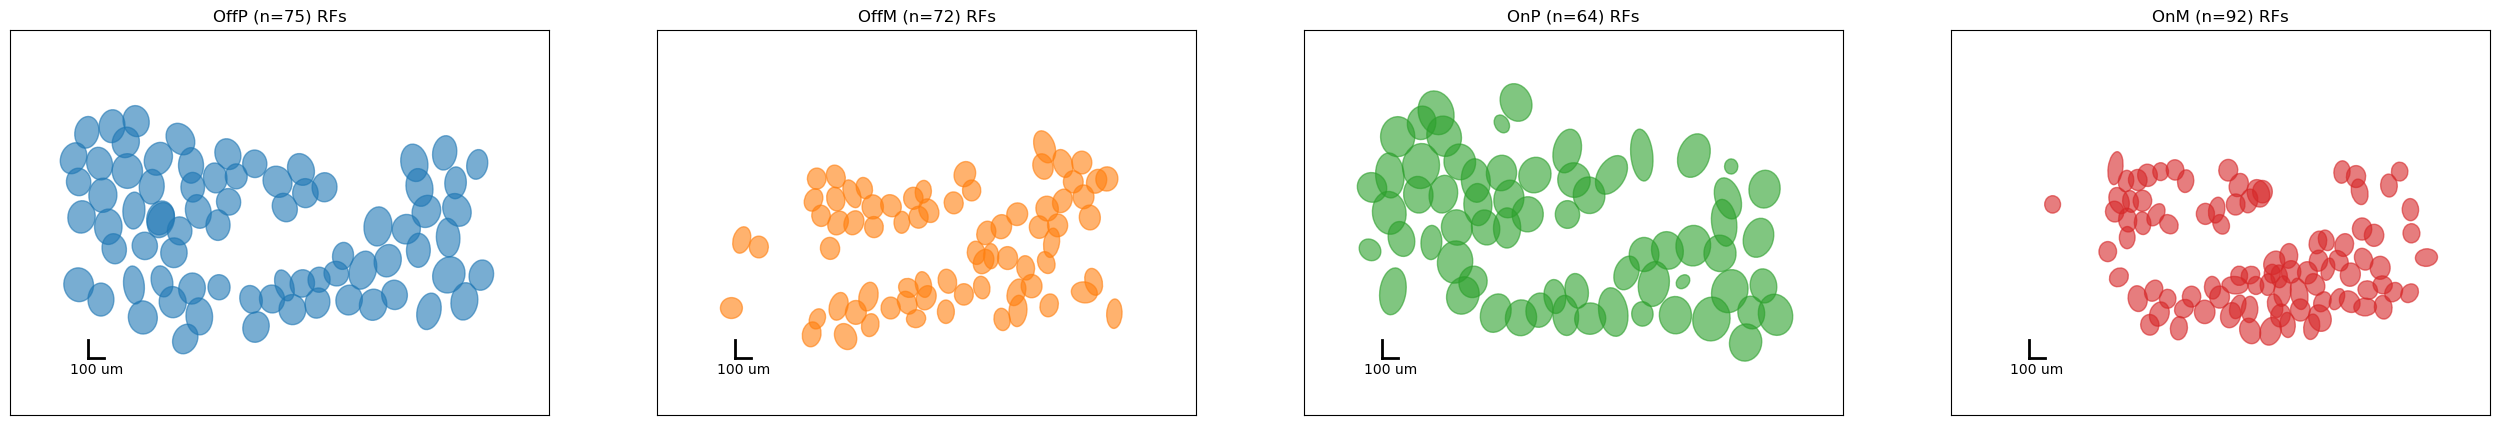

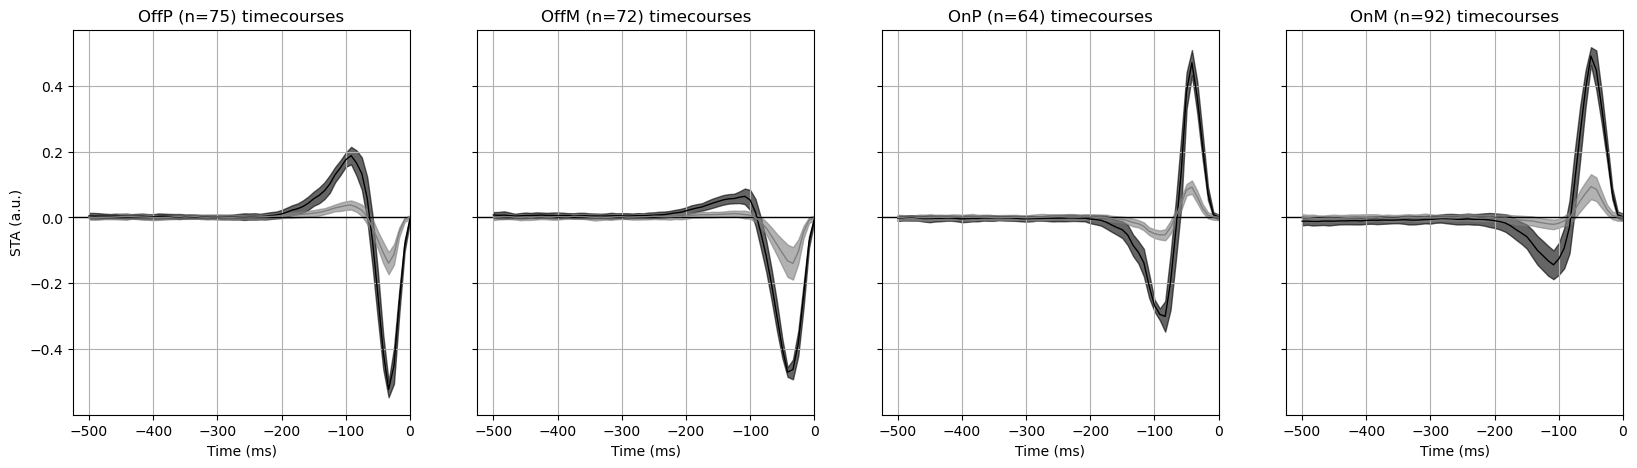

In [5]:
importlib.reload(sp)
sp.plot_type_rfs(data, sd_mult=0.8, b_zoom=True);
sp.plot_type_tcs(data);

## Get response spike times to WN

In [6]:
param_names = ['preTime', 'uniqueTime', 'repeatTime', 'tailTime', 'backgroundIntensity',
'frameDwells', 'gridSize', 'contrast', 'stixelSizes', 'chromaticClass',
'numXChecks', 'numYChecks', 'numFrames', 'numXStixels', 'numYStixels', 'stepsPerStixel',
'frameDwell', 'pre_frames', 'unique_frames', 'repeat_frames']
data.load_spike_times('SpatialNoise', param_names, bin_rate=1000.0, ls_filenames=data.ls_noise_filenames)


Processing group 1 of 1 and block 1 of 1


Processing epochs in block file data018: 100%|██| 16/16 [00:00<00:00, 51.76it/s]


Updating GOOD_CELL_IDS to 951 cells.
OffP: 75/75
OffM: 72/72
OnP: 64/64
OnM: 92/92
Loading ISI for SpatialNoise ['data018']...
Processing group 1 of 2 and block 1 of 1
Processing group 2 of 2 and block 1 of 1
Loaded ISI for 951 cells.


In [7]:
data.print_stim_summary()

Epoch length: 180500.00 ms
Total epochs: 16
pre: 250.00 ms; stim: 180000.00 ms; tail: 250.00 ms
pre pts: 250; stim pts: 180000; tail pts: 250
bin rate: 1000.00 Hz; bin dt: 1.00 ms


In [8]:
data.spikes['spike_dict'].shape, data.GOOD_CELL_IDS.shape, data.spikes['cluster_id'].shape

((951, 16), (951,), (951,))

In [9]:
data.N_HEIGHT, data.N_WIDTH

(95.0, 152.0)

In [50]:
data.stim['unique_params']

{'preTime': array([250.]),
 'uniqueTime': array([160000.]),
 'repeatTime': array([20000.]),
 'tailTime': array([250.]),
 'backgroundIntensity': array([0.5]),
 'frameDwells': array([1., 2.]),
 'gridSize': array([30.]),
 'contrast': array([1.]),
 'stixelSizes': array([60., 90.]),
 'chromaticClass': array(['BY'], dtype='<U2'),
 'numXChecks': array([152.]),
 'numYChecks': array([95.]),
 'numFrames': array([10635.]),
 'numXStixels': array([52., 77.]),
 'numYStixels': array([33., 49.]),
 'stepsPerStixel': array([2., 3.]),
 'frameDwell': array([1., 2.]),
 'pre_frames': array([], dtype=float64),
 'unique_frames': array([], dtype=float64),
 'repeat_frames': array([], dtype=float64)}

In [10]:
data.spikes.keys()

dict_keys(['spike_dict', 'cluster_id', 'bin_rate', 'n_bin_dt'])

In [11]:
# get frame times
import symphony_data as sd
c_data = sd.Dataset(data.str_experiment)
frame_times = c_data.get_frame_times('SpatialNoise', file_name=data.ls_noise_filenames)

Pulling frame times: 100%|██████████████████| 16/16 [00:00<00:00, 469292.76it/s]


Let's load the txt file of noise: doves cluster ID mapping as it may be useful later.

In [12]:
str_ei_map_dir = '/Users/niloughazavi/Documents/Mike_Data/analysis/20240229C/chunk4/kilosort2/chunk4_to_doves_ei/'
str_mapping_txt = os.path.join(str_ei_map_dir, 'chunk4_to_doves.txt')
d_mapping = eicorr.load_mapping(str_mapping_txt)

In [13]:
noise_cluster_ids = data.spikes['cluster_id']
doves_cluster_ids = []
for n_id in noise_cluster_ids:
    if n_id in d_mapping:
        doves_cluster_ids.append(d_mapping[n_id])
    else:
        doves_cluster_ids.append(-1)
doves_cluster_ids = np.array(doves_cluster_ids)

# Output structure

In [14]:
d_save = {'spike_dict': data.spikes['spike_dict'],
          'noise_cluster_id': noise_cluster_ids,
          'doves_cluster_id': doves_cluster_ids,  
          'backgroundIntensity': data.stim['params']['backgroundIntensity'],
          'pre_pts': data.stim['n_pre_pts'],
          'stim_pts': data.stim['n_stim_pts'],
          'tail_pts': data.stim['n_tail_pts'],
          'bin_rate': data.stim['bin_rate'],
          'frame_rate': 59.941548817817917,
          'numXChecks': data.N_WIDTH,
          'numYChecks': data.N_HEIGHT,
          'frame_times': frame_times,
          'cell_types': data.types.d_main_IDs}

In [15]:
str_save = '/Users/niloughazavi/Documents/Mike_Data/Nilou_MEA/spikeoutputs/dovesmovie/20240229C_SpatialNoise_kilosort2_data018_spiketimes.pkl'
with open(str_save, 'wb') as f:
    pickle.dump(d_save, f)

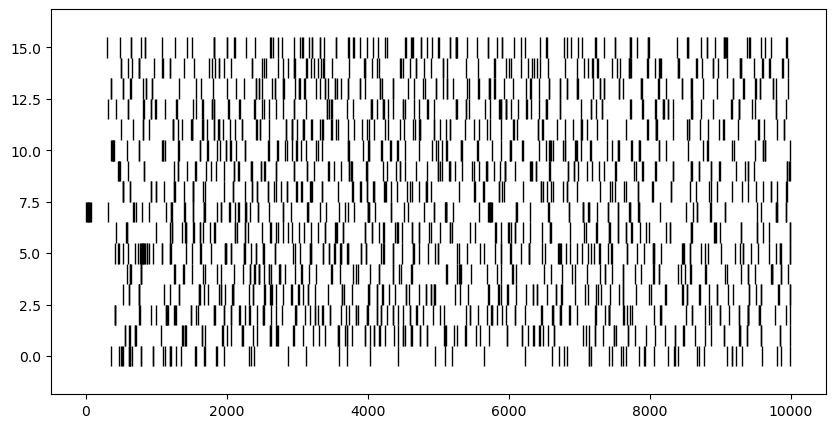

In [16]:
# See example spiketime
eg_id = data.get_type_ids('OnP')[1]
eg_idx = np.where(data.spikes['cluster_id'] == eg_id)[0][0]
eg_spike_times = data.spikes['spike_dict'][eg_idx]
f, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, st in enumerate(eg_spike_times):
    st = st[st<10000] 
    ax.eventplot(st, lineoffsets=i, colors='k', linelengths=1, linewidths=1)

In [37]:
len(noise_cluster_ids)

951